In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.pipeline import Pipeline
from scipy import io
import time


In [15]:
def get_data(ntrain, ntest):
    sub_x = 2 ** 6
    sub_y = 2 ** 6

    # Data is of the shape (number of samples = 2048, grid size = 2^13)
    data = io.loadmat("burgers_data_R10.mat")
    x_data = data["a"][:, ::sub_x].astype(np.float64)
    y_data = data["u"][:, ::sub_y].astype(np.float64)
    x_branch_train = x_data[:ntrain, :]
    y_train = y_data[:ntrain, :]
    x_branch_test = x_data[-ntest:, :]
    y_test = y_data[-ntest:, :]
    
        
    s = 2 ** 13 // sub_y  # total grid size divided by the subsampling rate
    grid = np.linspace(0, 1, num=2 ** 13)[::sub_y, None]

    return x_branch_train, y_train, x_branch_test, y_test, grid

x, y, x_test, y_test, grid = get_data(1000, 200)
print(y_test.shape)

(200, 128)


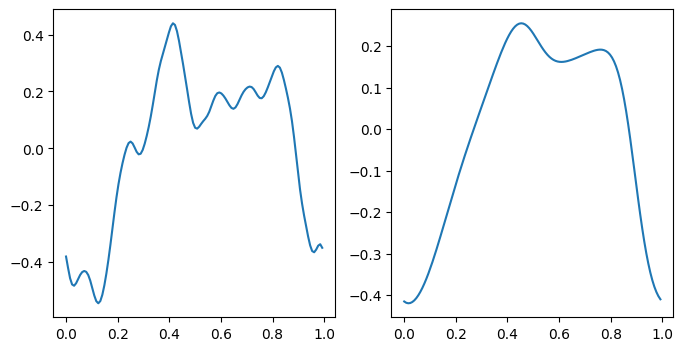

In [16]:
idx = 2

fig, axs = plt.subplots(1, 2, figsize=(4*2,4))
axs[0].plot(grid, x[idx])
axs[1].plot(grid, y[idx])

# plt.xlabel(r'$x$', size= 15)
# plt.ylabel(r'$u_0(x)$', size= 15)


Best parameters: {'regression__alpha': 2}
Best cross-validation relative MSE score: 0.11107839360639468
Relative Mean Squared Error: 0.0005318252700812453
Test Mean Squared Error: 0.00012646184321467587


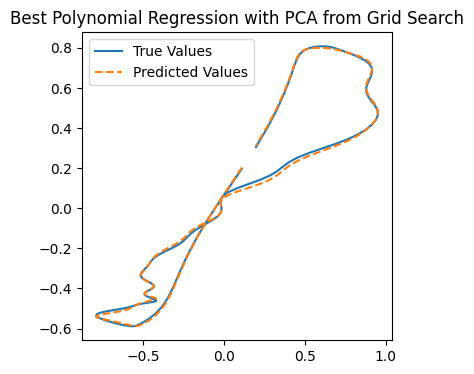

In [19]:
def mse_relative(y_true, y_pred):
    """
    :param y_true:
    :param y_pred:
    :return: average relative mse
    """
    # Handle y_true is zero
    non_zero_mask = y_true != 0
    return np.mean(np.square(np.linalg.norm(y_true[non_zero_mask] - y_pred[non_zero_mask], axis=-1) / np.linalg.norm(y_true[non_zero_mask], axis=-1)))

X_train, y_train, X_test, y_test, _ = get_data(8000, 2000)

# Framework Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(0.99999)),
    ('poly_features', PolynomialFeatures(3)),
    ('regression', Ridge())
])

# Parameters for Grid Search
param_grid = {
    'regression__alpha': [1,2]
}

# Custom scorer for grid search
custom_scorer = make_scorer(mse_relative, greater_is_better=False)

# Grid search CV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=custom_scorer)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation relative MSE score:", -grid_search.best_score_)

# Evaluate on test set using the best model
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)
relative_mse = mse_relative(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
print(f"Relative Mean Squared Error: {relative_mse}")
print(f"Test Mean Squared Error: {mse}")

# Plot
plt.figure(figsize=(4, 4))
plt.plot(X_test[200], y_test[200], label='True Values')
plt.plot(X_test[200], predictions[200], label='Predicted Values', linestyle='--')
plt.legend()
plt.title("Best Polynomial Regression with PCA from Grid Search")
plt.show()

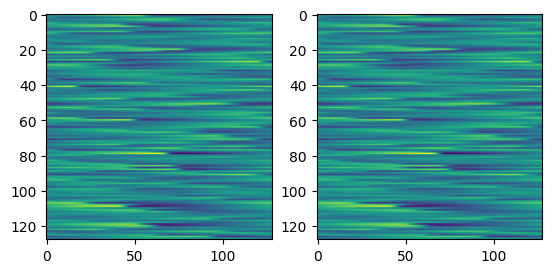

In [20]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(y_test[0:128,:])
axs[1].imshow(predictions[0:128,:])
plt.show()